# Reverse Engineering

In the following I will present a few things I learned about the data through "*reverse data engineering*". The main idea was to learn enough of the underlying process to be able to propose simple models from which I could simulate data, which in turn I could compare to the observed data to test the fit. Unfortunately however, in the end I did not learn enough to beat my final black-box algorithms in terms of prediction on the validation set, which is why I did not pursue this path any further. Nevertheless the insights made here can still be interesting. If, however, you wish to jump right to the final model please skip this section.

## Preliminaries

In [1]:
import os
import importlib
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import lars_path
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.gaussian_process.kernels import Matern

from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import t

from IPython.display import Video

ROOT = Path(os.getcwd()).parent

# load module using path (I am to lazy to make a python package out of this project..)
spec = importlib.util.spec_from_file_location("shared.py", str(ROOT / "shared.py"))
shared = spec.loader.load_module()

plt.rcParams['figure.figsize'] = [10, 6]
colors = ["#DAA520", "#4169E1", "#228B22", "#A52A2A"]
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

In [2]:
df = pd.read_parquet(ROOT / "bld" / "train_simulated.parquet")
X = df.drop("Y", axis=1)
y = df["Y"]

## Features

By construction our data set consists of $K=100$ features which are transformed to be uniformly distributed on $[0, 1]$.
Unfortunately this is all the prior knowledge we have.

Looking at the correlation between features we notice that the correlation structure looks very similar to the covariance structure of a [Matérn covariance function](https://en.wikipedia.org/wiki/Mat%C3%A9rn_covariance_function). This can be seen especially well when considering a correlation heatmap of the observed features.

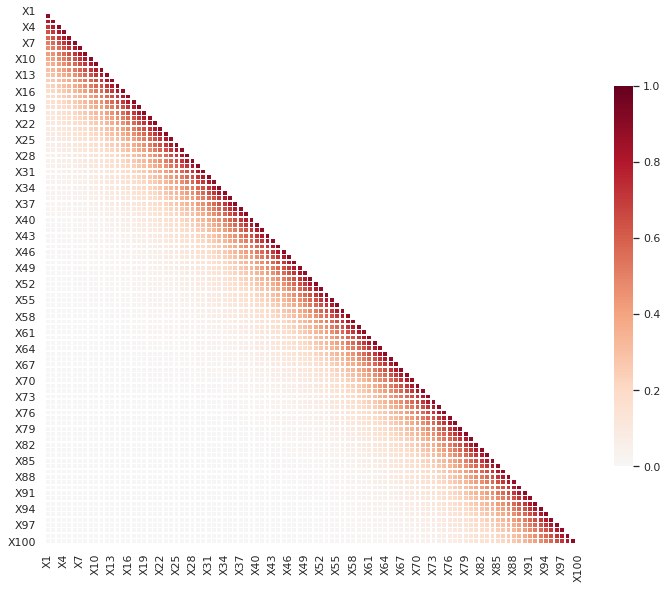

In [5]:
shared.correlation_heatmap(df=X)

For a comparison, consider a (true) Matérn covariance heatmap.

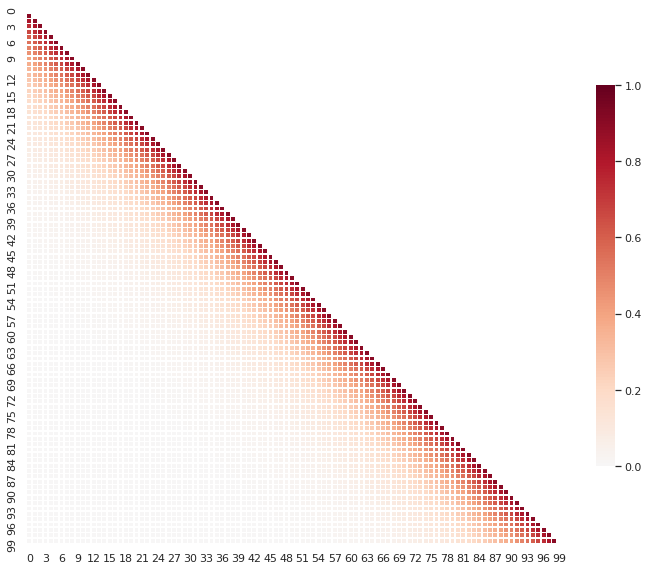

In [6]:
matern_kernel = Matern(length_scale=0.1, nu=0.5)

x = np.linspace(0, 1, 100).reshape(100, -1)
Sigma = matern_kernel(x)

shared.correlation_heatmap(corr=Sigma)

### Simulation?

Given the hypothesis that the features were simulated using the Matern covariance matrix, can we actually formulate an algroithm for this simulation step?

Let $Z$ denote a $K$ dimensional random vector.
If we assume that the individual entries $Z_k$ have unit standard deviation, then $\text{corr}(Z) = \text{cov}(Z)$.

Hence, we can simulate features with the structure from above using the following simple algorithm. For this let $\Sigma$ denote the above Matérn covariance matrix (parameterized with $\ell = 0.1$ and $\nu$ = 0.5).

**Algorithm**:
1. Draw samples $Z^{(i)}$ from $\mathcal{N}(0, \Sigma)$ for $i=1,\dots,n$
2. Transform each sample to a uniform by $X^{(i)}_j = \Phi(Z^{(i)}_j)$ for each $i=1,\dots,n ; j=1,\dots,K$

where $\Phi$ denotes the standard normal cumulative distribution function.

To check wether this works let us simulate a small data set in this fashion. We need to check that the empirical correlation matrix resembles the ones from above, and that the marginal distributions are approximately uniform.

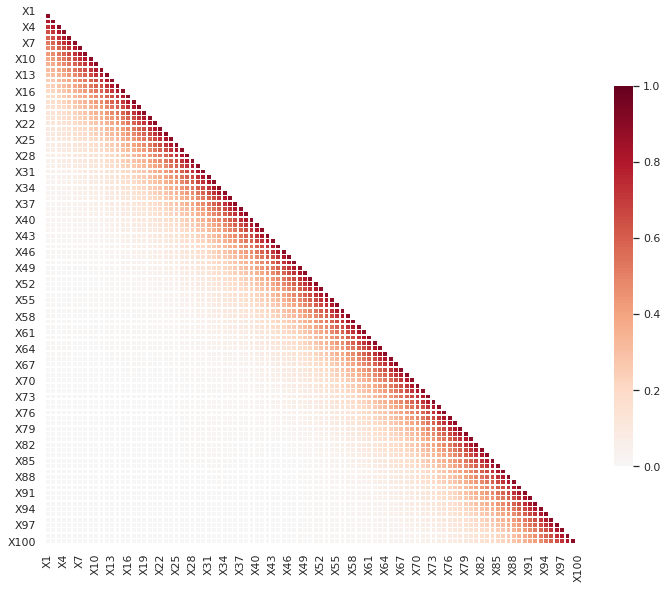

In [7]:
n = 25_000
mvnormal = multivariate_normal(cov=Sigma)
Z = mvnormal.rvs(n, random_state=0)

columns = [f"X{k}" for k in range(1, 101)]
XX = norm.cdf(Z)
XX = pd.DataFrame(XX, columns=columns)

shared.correlation_heatmap(XX)

And checking that each column is really uniform distributed by considering a histogram (here we select a few columns randomly since looking at all 100 is too annoying..)

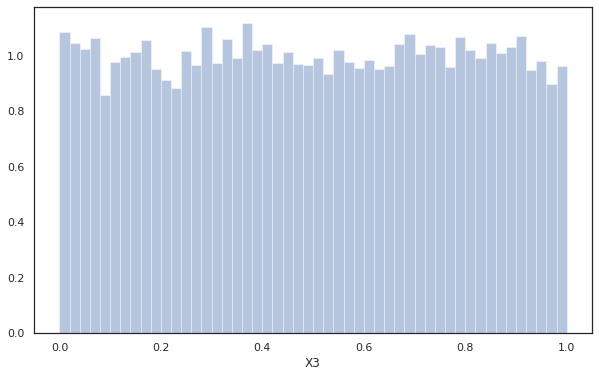

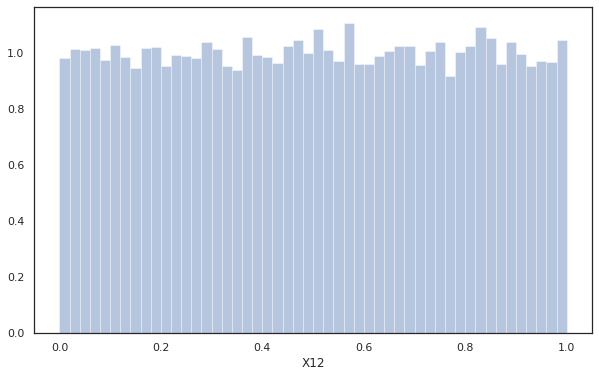

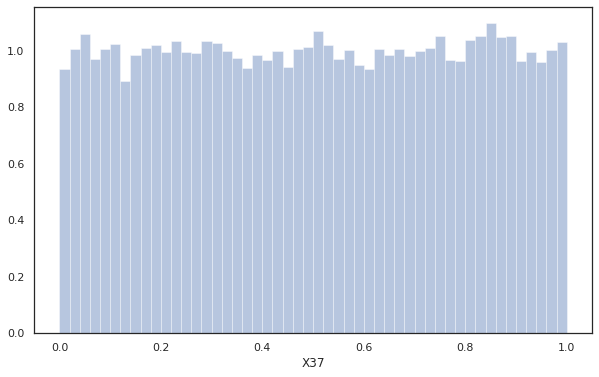

In [8]:
for col in ["X3", "X12", "X37"]:
    sns.distplot(
        XX[col], 
        bins=50,
        norm_hist=True,
        kde=False,
        hist_kws={"range": [0, 1]}
    )
    plt.show()

### Recap - Features

We have seen that the covariance/correlation structure of the features is very similar to a Matern covariance.
A major component of feature analysis is to check wether one can reduce the dimensionality of the feature set.
As all our features are distributed identically and the correlation structure does not admit any grouping we cannot apply classical techniques such as PCA for sensible dimensionality reduction.
This means if we want to reduce the dimensionality we have to actually find and eliminate the features that are unrelated with the outcome or have a negligible effect.

## Outcomes

To learn more about the outcome structure I fit the parameters of a normal and t distribution on the outcomes, plot the outcomes using a histogram and draw the two distributions on top. Visualizing the outcome distribution can be important to check wether one needs to transform the distribution, e.g. in the case of positive data.

In [9]:
mle_tuple_t = t.fit(y.values.flatten(), floc=y.values.mean())
mle_tuple_norm = norm.fit(y.values.flatten())

t_distr = t(*mle_tuple_t)
norm_distr = norm(*mle_tuple_norm)

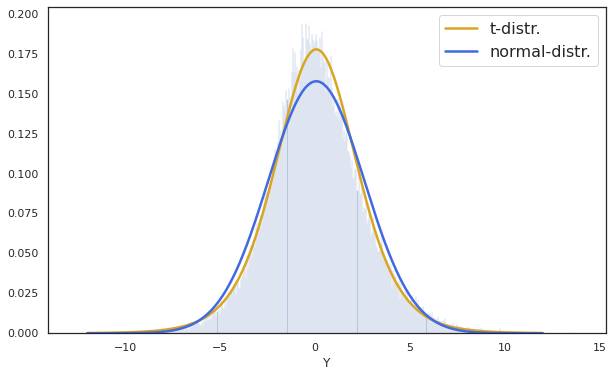

In [10]:
x = np.linspace(-12, 12, 1000)
ax = sns.distplot(y, kde=False, norm_hist=True, bins=500)
ax.plot(x, t_distr.pdf(x), linewidth=2.5, color="goldenrod")
ax.plot(x, norm_distr.pdf(x), linewidth=2.5, color="royalblue")
ax.legend(['t-distr.', 'normal-distr.'], prop={'size': 16})
plt.show()

From the plot we can see that the outcomes are more tightly centered than we would expect from a normal distribution. The fitted t-distribution fits the outcome distribution better but still not optimal. Nevertheless if we are willing to assume exogeneity and an additive error structure, we would expect from the above plot that the model errors follow a more tightly centered distribution with large tails rather than a normal.

The most important insight from the above plot is that there is no need to transform the outcome for a better model fit, as is the case for constrained or positive data.

## Relationship Between Outcomes and Features

To better understand how the outcomes are affected by the features I consider one dimensional regression plots. That is, for each feature $X_k$ ($k=1,\dots,K$) I consider the plot of $Y$ vs. $X_k$.
(Offline I also considered all two dimensional interaction plot but these are too many to be displayed here and they did not provide any useful insights.)

Since $K$ (=100) plots are quite a few plots I simpy show a video where we iterate through all plots very fast...

The black line seen in the plot denotes the regression line for the model $Y \sim \beta_0 + \beta_1 X_k + \beta_2 X_k^2 + \beta_3 X_k^3$.

In [19]:
Video(ROOT / "figures" / "no_interaction.mp4", embed=True, html_attributes="controls muted")

It is clear that from these univariate effect plots we cannot read-off the entire model, nevertheless these plots contain a great amount of information.

Firstly, we see that "the effect of $X_k$ on $Y$" is, in a sense, *continuous* in $k$.
That makes sense since we already observed that the features follow a Matern style covariance structure which implies that neighboring features (here: neighboring in the sense that the $k$'s are close) are heavily correlated.
Hence, we would expect that these neighboring features *look like* they have a similar effect on the outcome.

Secondly, we see that for many $k$'s the effect looks negligible.
In the next steps we analyze this structure of the data more closely and try to establish a more quantitative answer to whether some features are irrelevant.

Lastly, before jumping into a quantitative analysis let me provide a guess on how the above data structure could have emerged.
Say we model the outcomes using an additive model and each component is modeled by a 3rd degree polynomial.
We then pick a few features, say 2-5, and give them non-zero coefficients.
Since the features were created with the special covariance structure from above we would expect that for all features that are close to features with non-zero coefficients, the estimated coefficents would also be non-zero, but shrunk towards zero.

### Quantitative Analysis

To get a more quantatitive understanding of which features matter I will 

1. Fit a regularized linear model (first-degree, second-degree) using the Lasso and disregard features with zero-coefficient
2. Use a recursive feature elimination with cross-validation
3. Fit a third-degree ridge regression for each feature dimension and compare coefficients

    
I wont dive too deep into the details of each approach as in the end I decided to pusue a very different route.

Each of the following approaches could have been used to select a small subset of features on which another model could have been fit in a second stage. I did not pursue this strategy in my final model, which is why I do not provide any detailed explainations. Nevertheless the results from below convinced me that the main effects in the data are sparse, which led me to choose hyperparameters in my final machine learning model that perform better under sparsity. This approach also goes well with the "Bet on Sparsity" principle, on which Rob Tibshirani writes:

>Hastie et al. (2001) coined the informal “Bet on Sparsity” principle. The l1 methods assume that the truth is sparse, in some basis. If the assumption holds true, then the parameters can be efficiently estimated using l1 penalties. If the assumption does not hold—so that the truth is dense—then no method will be able to recover the underlying model without a large amount of data per parameter.

#### The Lasso Approach

To find relevant features we fit a l1 regularized linear model with a) all first-degree terms and b) all first-degree, second-degree and first-degree-interaction terms. For case a) I will also plot the Lasso path. I won't do that for case b) since there will be too many coefficients.

For both approaches I find the *optimal* regularization parameter via 5-fold cross-validation on 50 different alphas.

***a: first-degree***

In [12]:
lasso_model = LassoCV(eps=0.05, n_alphas=50, cv=5)
lasso_model = lasso_model.fit(X, y)

relevant = X.columns[lasso_model.coef_ != 0].to_list()
print("Relevant features chosen via Lasso:", relevant)

Relevant features chosen via Lasso: ['X3', 'X12', 'X13', 'X14', 'X37', 'X38', 'X39', 'X44']


.

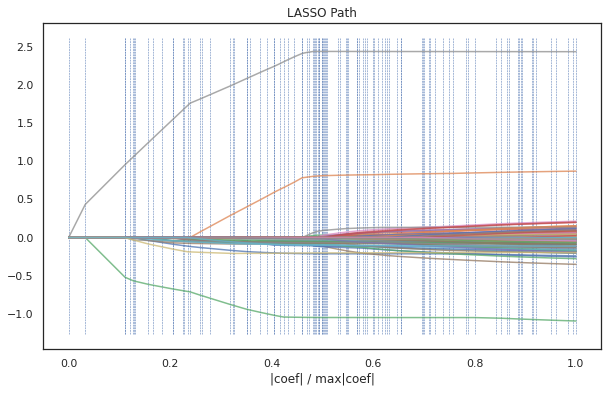

In [13]:
_, _, coefs = lars_path(X.values, y.values, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T, alpha=0.75)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed', lw=0.5)
plt.xlabel('|coef| / max|coef|')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

***b: second-degree***

In [14]:
poly = PolynomialFeatures(degree=2, include_bias=False)

XX = poly.fit_transform(X)
poly_columns = [
    col.replace(" ", ":") for col in poly.get_feature_names(X.columns)
]
XX = pd.DataFrame(XX, columns=poly_columns)

In [15]:
lasso_model_poly = lasso_model.fit(XX, y)

relevant_poly = XX.columns[lasso_model_poly.coef_ != 0].to_list()
print("Relevant features chosen via Lasso:", relevant_poly)

Relevant features chosen via Lasso: ['X3', 'X5', 'X37', 'X38', 'X57', 'X92', 'X3:X5', 'X3:X12', 'X3:X57', 'X3:X90', 'X5:X9', 'X9:X12', 'X12^2', 'X12:X14', 'X35^2', 'X38:X39', 'X38:X40', 'X38:X47', 'X38:X57', 'X38:X92', 'X38:X93', 'X38:X94', 'X39^2', 'X90^2']


#### Recursive Feature Elimination with CV

As above, I will not dive too deep into the inner workings of the RFECV function as this it not my main model / model selection tool. Here I will apply it on only on the first order effects.

The main idea is to recursively consider smaller and smaller subsets of features. I use 5-fold CV to compute the *optimal* subset and plot the negative mean squared error against the number of features.

***Note.*** As mentioned above I only include the first order effects here since the number of terms explodes when also considering the interactions terms. Still, for each included regressor one could fit a 4th degree polynomial instead of the 1st degree effect I consider below.

In [1]:
linear_model = LinearRegression()
rfecv = RFECV(estimator=linear_model, step=1, cv=5, scoring="neg_mean_squared_error")
rfecv.fit(X, y)
print("Optimal subset of features: ", X.columns[rfecv.get_support(True)].to_list())

NameError: name 'LinearRegression' is not defined

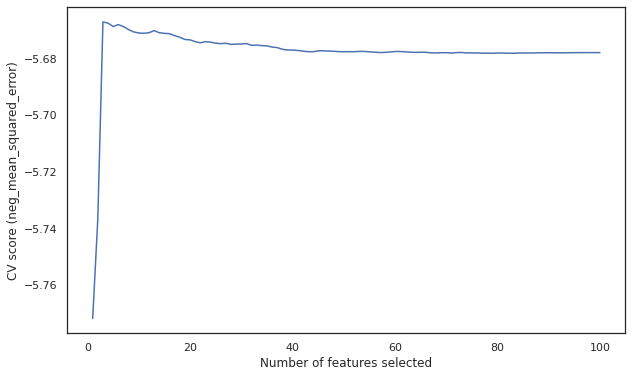

In [18]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("CV score (neg_mean_squared_error)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

#### The Ridge Comparison Approach

In this last approach the overall goal is to fit a third-degree linear model with l2 regularization, i.e. a ridge regression, for all features and plot the coefficient values with the feature index on the x-axis. In particular I fit the model $Y \sim \beta_0 + \sum_{k=1}^K \beta_{1k} X_k + \beta_{2k} X_k^2 + \beta_{3k} X_k^3$ using an l2 regularization and set all coefficients which are below some threshold (here 0.75) to zero. The results are compared across $k$. The regularization parameter is chosen via 5-fold cross validation.

In [34]:
XX = pd.concat([X ** k for k in range(1, 4)], axis=1)

alphas = np.logspace(-5, 1, num=20)
ridge = RidgeCV(cv=5, alphas=alphas).fit(XX, y)

df_coef = pd.DataFrame(
    ridge.coef_.reshape((-1, 3), order="F"),
    columns=["beta1", "beta2", "beta3"],
    index=range(1, len(X.columns) + 1)
)

threshold = 0.75
df_coef[df_coef.abs() < threshold] = 0
df_coef = df_coef.rename_axis(
    "feature_id", axis=0
).reset_index().melt(id_vars="feature_id", var_name="coef")
df_coef["value"] = df_coef["value"].astype(float)

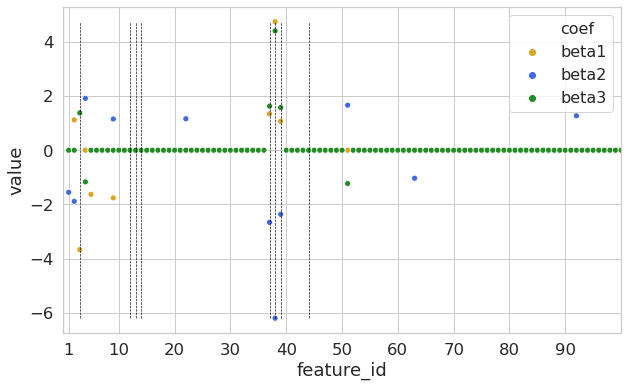

In [45]:
plt.figure()
ax = sns.scatterplot(
    x="feature_id", y="value", hue="coef", data=df_coef
)
ymax, ymin = df_coef["value"].max(), df_coef["value"].min()
ax.vlines([3, 12, 13, 14, 37, 38, 39, 44], ymin=ymin, ymax=ymax, color="black", lw=0.65, linestyle="dashed")
plt.legend(prop={'size': 16})
plt.xlim(0, 100)
plt.xticks((1,) + tuple(range(10, 100, 10)))
_ = plt.plot()

The dashed black lines represent features that were selected by the first-order Lasso approach

## Conclusions  (so far)

In all of the methods considered above we have seen that only very few features are selected and accross approaches the same (or at least neighboring) features were selected consistently. This leads me to believe that, as mentioned before, the main effect of the problem is sparse. I would have enjoyed using a simple third-degree polynomial model with subsetted features. Sadly, when compared on the validation set I get a substantially lower prediction error using some of the machine learning methods presented next.